<a href="https://colab.research.google.com/github/jessicanadalete/Rossmann_DS_project/blob/main/Rossmann_DSemProducao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Imports

In [1]:
pip install inflection

In [2]:
pip install boruta

In [96]:
import pandas as pd
import datetime
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats as ss
from IPython.core.display import HTML
from IPython.display import Image
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Lasso
from boruta import BorutaPy

###1.1 Helper Functions

In [4]:
def cramer_v( x, y ):
  cm = pd.crosstab( x, y )
  n = cm.sum().sum()
  r, k = cm.shape

  chi2 = ss.chi2_contingency( cm )[0]

  chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)

  return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [5]:
def ml_error(model_name, y, yhat):
  mae = mean_absolute_error(y, yhat)
  mape = mean_absolute_percentage_error(y, yhat)
  rmse = np.sqrt(mean_squared_error(y, yhat))

  return pd.DataFrame({'Model Name': model_name,
                       'MAE': mae,
                       'MAPE': mape,
                       'RMSE': rmse}, index=[0])

###1.2 Loading Data

In [6]:
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)

#merge dasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store" )

#2.0 Data Description

##2.1 Rename Columns

In [7]:
#creating data copy before initiating a new session

df1 = df_raw.copy()

In [8]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename columns
df1.columns = cols_new

In [10]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

###2.2 Data Dimension

In [11]:
#numer of rows and columns
df1.shape

(1017209, 18)

###2.3 Data Types

In [12]:
df1.dtypes

,0
store,int64
day_of_week,int64
date,object
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


In [13]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


###2.4 Check NA

In [14]:
#checking the sum of NA in each column
df1.isna().sum()

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


###2.5 Fillout NA

In [15]:
df1['competition_distance'].max()

75860.0

In [16]:
#competition distance = distance in meters to the nearest competidor store
#-> considering that NA is when the store doesnt have any competidor near, we'll input a bigger distance then max distance in the data
# here Im using only one column
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month and year = year and month of the time the nearest competidor was opened
#->assumption: considering the same date of the sale
#obs: here Im using more than one column of my dataframe
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week = store participating or not of promotion
#-> same assumption of line above

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year = store participating or not of promotion
#-> same assumption of line above

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval

month_map = {1: 'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [17]:
#checking the sum of NA in each column
df1.isna().sum()

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


###1.6 Change Types

In [18]:
df1.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

###1.7 Descriptive Statistical

In [20]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [21]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


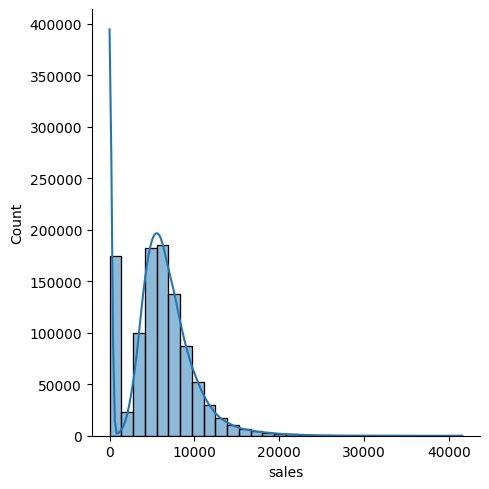

In [22]:
sales_plot = sns.displot(df1['sales'], kde = 'True', bins=30)

#sales_plot.ax.set_xlim(0, 20000)
#sales_plot.ax.set_ylim(0, 12500)

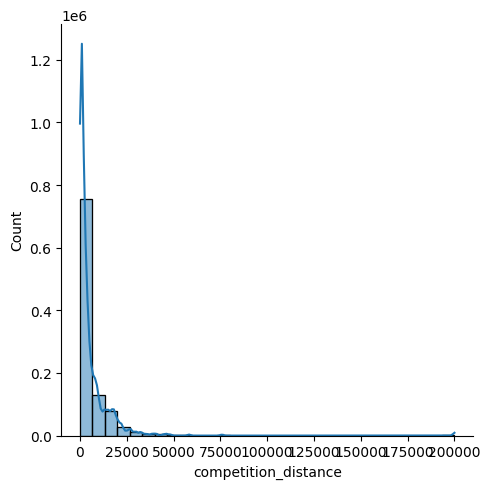

In [23]:
cd_plot = sns.displot(df1['competition_distance'], kde= 'True', bins=30)

###1.7 Categorical Attributes

In [24]:
cat_attributes.apply(lambda x: x.unique().shape[0])

,0
state_holiday,4
store_type,4
assortment,3
promo_interval,4
month_map,12


<Axes: xlabel='state_holiday', ylabel='sales'>

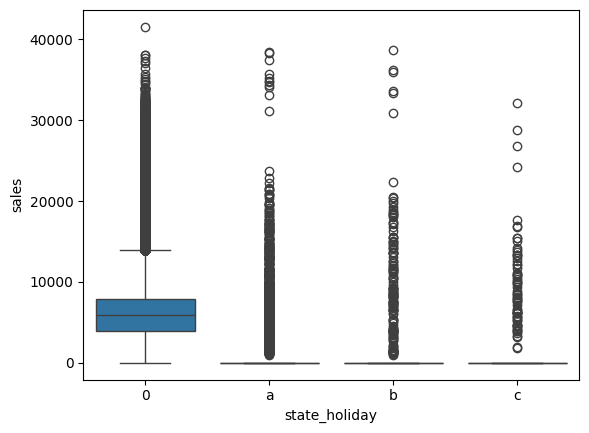

In [25]:
sns.boxplot(x='state_holiday', y='sales', data=df1)

<Axes: xlabel='assortment', ylabel='sales'>

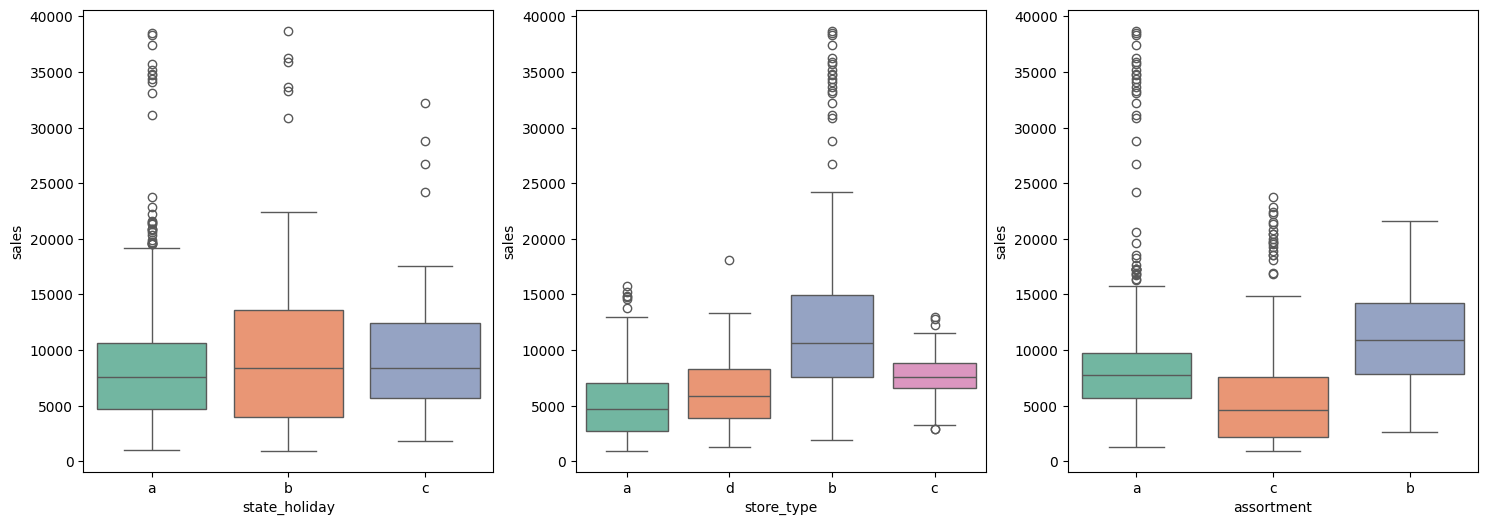

In [26]:
#filtering data considerating sales = 0 - stores closed

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='state_holiday', y='sales', hue='state_holiday', data=aux1, ax=axes[0], palette='Set2', legend ='auto')

sns.boxplot(x='store_type', y='sales', hue='store_type', data=aux1, ax=axes[1], palette='Set2', legend ='auto')

sns.boxplot(x='assortment', y='sales', hue='assortment', data=aux1, ax=axes[2], palette='Set2', legend ='auto')

#3.0 Feature Enginnering



In [27]:
df2 = df1.copy()

###3.1 Mind Map Hypotesis

In [28]:
#Image('/content/DAILY_STORE_SALES.png')

###3.2 Hypotesis Creation

####3.2.1 Store Hypotesis

**1.** Stores with more assortment should sell more.

**2.** Stores with nearest competitors should sell less.

**3.** Stores that have been with competitors for longer should sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotions days should sell more.

**6.** Stores with consecutve promotions should sell more.


####3.2.1 Product Hypotesis

####3.2.2 Time Hypotesis

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

###3.3 Variable Creation

In [29]:
#creating variables from date

#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#creating variables from competition column

#competition since

#df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / np.timedelta64(1, 'm')).astype(int)

df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = (((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int))

#changing variables

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [30]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


###3.4 Row Filtering

In [31]:
df3 = df2.copy()

In [32]:
# considering that closed stores dont have sales
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

###3.5 Column Selection

In [33]:
# removing column 'costumer' - because we dont know the number of future constumers, column 'open' - because it dont give useful information and another support columns
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

#4.0 Exploratory Data Analysis

In [34]:
df4 = df3.copy()

###4.1 Response Variable

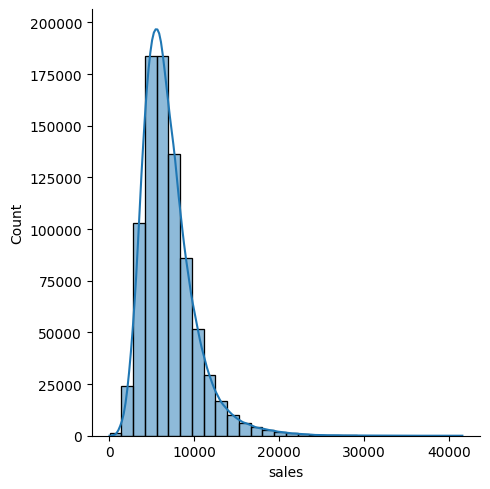

In [35]:
sns.displot(df4['sales'], kde='True', bins=30)

###4.2 Numerical Variable

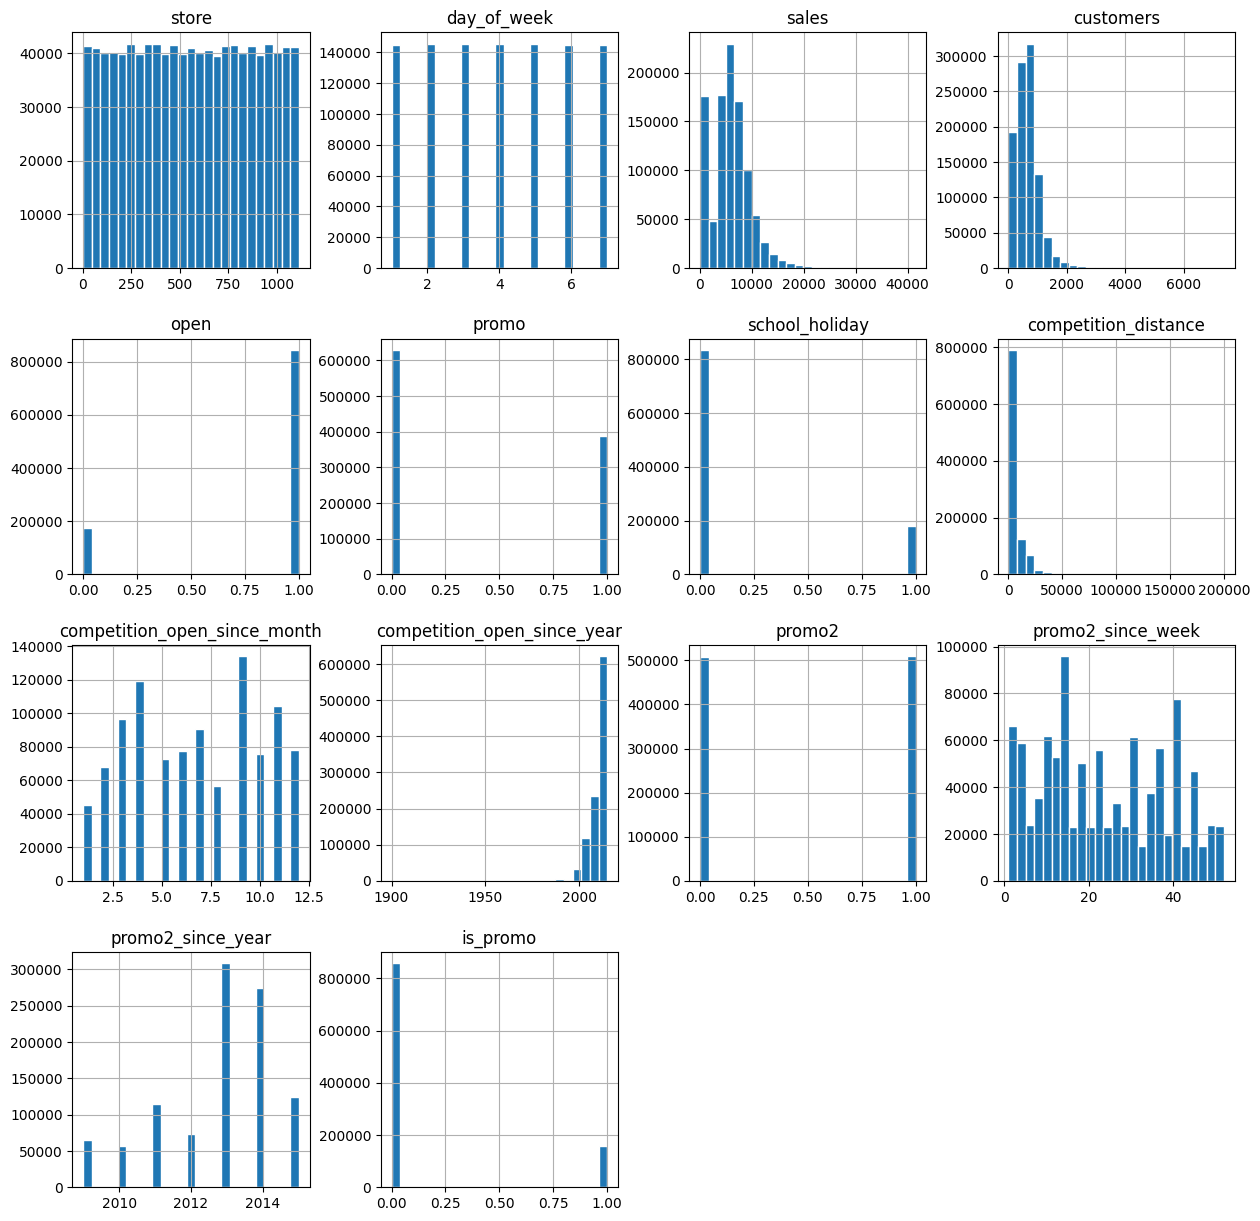

In [36]:
num_attributes.hist(bins=25, figsize=(15,15), edgecolor='white');

###4.3 Categorical Variable

###4.3.1 Univariate Analysis

In [37]:
df4['state_holiday'].drop_duplicates()

,state_holiday
0,regular_day
63559,public_holiday
129424,easter_holiday
241126,christmas


In [38]:
df4['store_type'].drop_duplicates()

,store_type
0,c
1,a
12,d
84,b


In [39]:
df4['assortment'].drop_duplicates()

,assortment
0,basic
3,extended
258,extra


<Axes: xlabel='sales', ylabel='Density'>

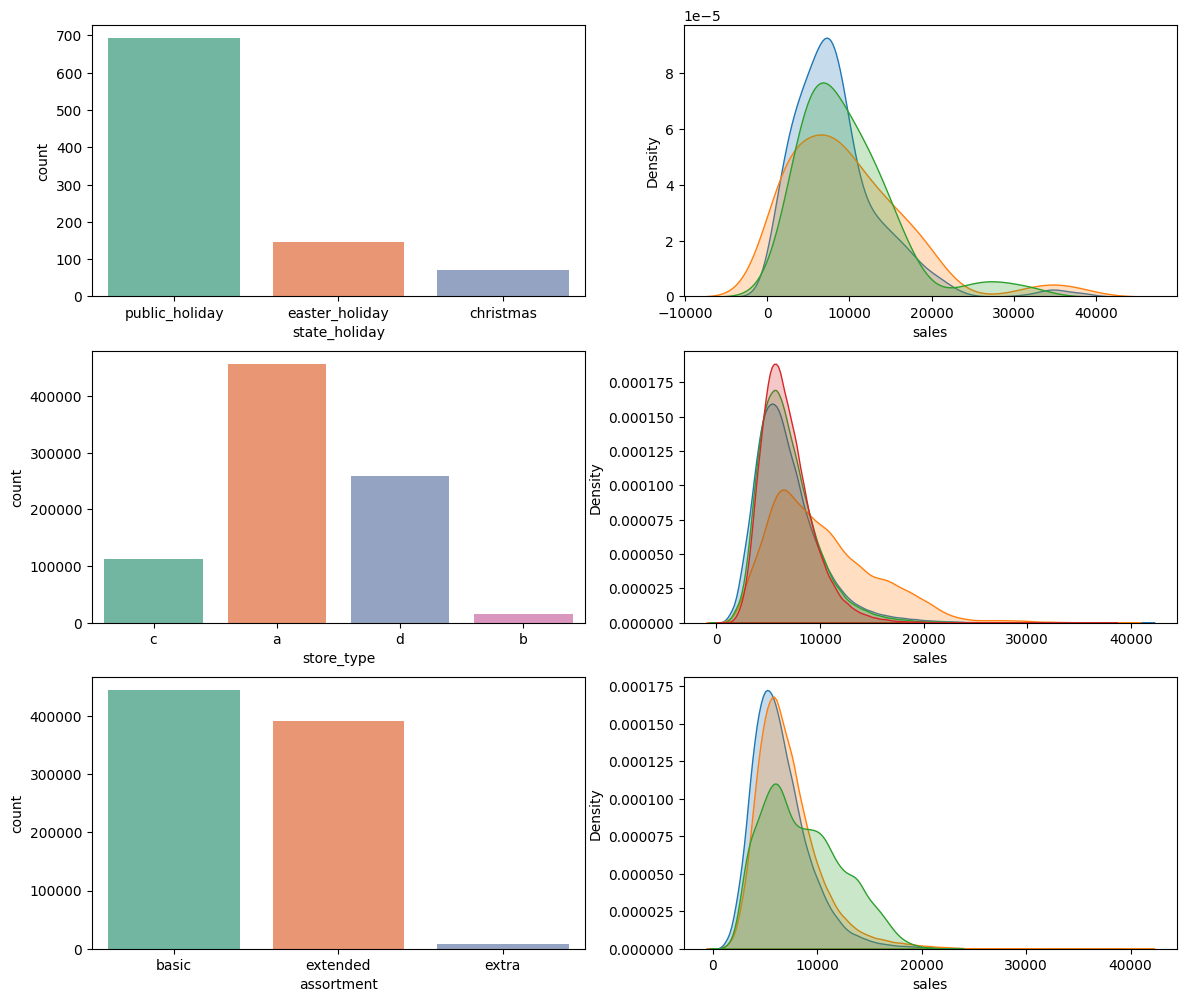

In [40]:
#state_holiday

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

df4_filtered = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', hue='state_holiday', data=df4_filtered, palette='Set2', ax=axes[0, 0])


sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True, ax=axes[0,1])
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True, ax=axes[0,1])
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True, ax=axes[0,1])

#store_type

sns.countplot(x='store_type', hue='store_type', palette='Set2', data=df4, ax=axes[1,0])


sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], fill=True, ax=axes[1,1])
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], fill=True, ax=axes[1,1])
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], fill=True, ax=axes[1,1])
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], fill=True, ax=axes[1,1])

#assortment

sns.countplot(x='assortment', hue='assortment', data=df4, palette='Set2', ax=axes[2,0])

sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], fill=True, ax=axes[2,1])
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], fill=True, ax=axes[2,1])
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], fill=True, ax=axes[2,1])

In [41]:
df4['year_week']

,year_week
0,2015-30
1,2015-30
2,2015-30
3,2015-30
4,2015-30
...,...
1016776,2013-00
1016827,2013-00
1016863,2013-00
1017042,2013-00


###4.3.2 Bivariate Analysis: Validating some hypotesis

####**Validating H1.** Stores with more assortment should sell more.
#####**FALSE** -> **Stores with MORE ASSORTMENT sell LESS.**

<Axes: xlabel='year_week'>

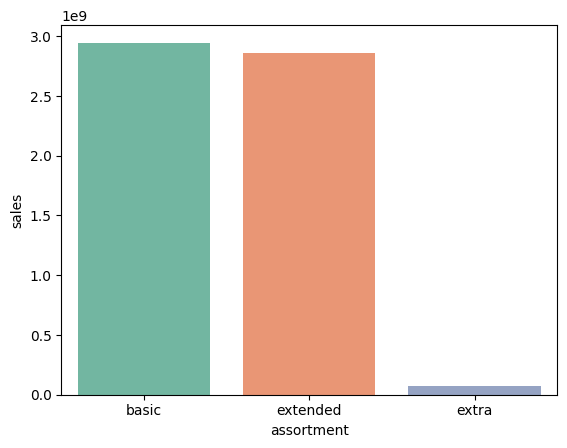

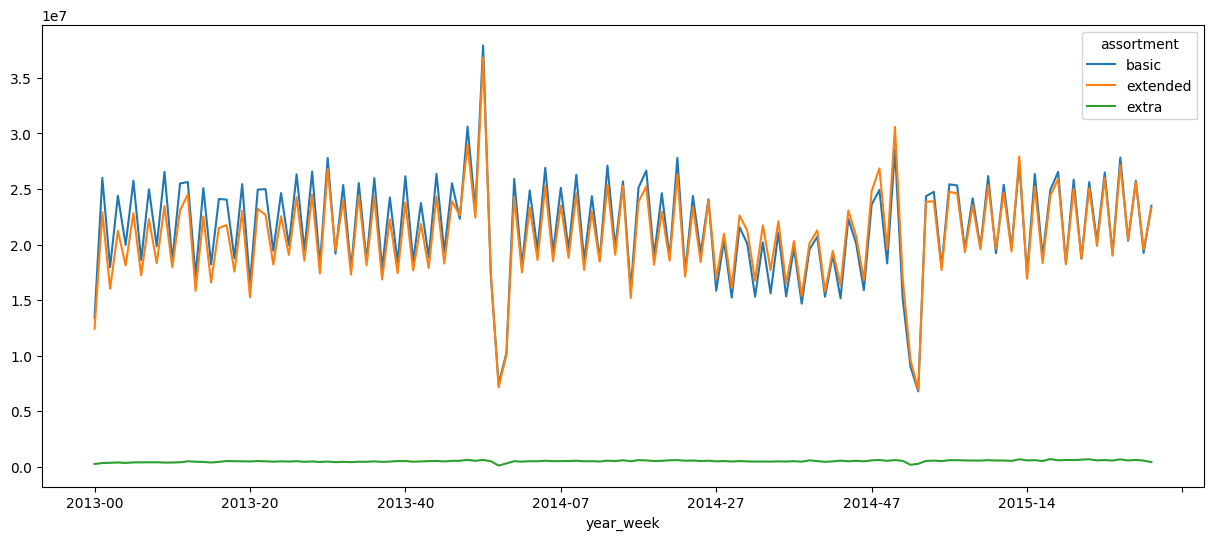

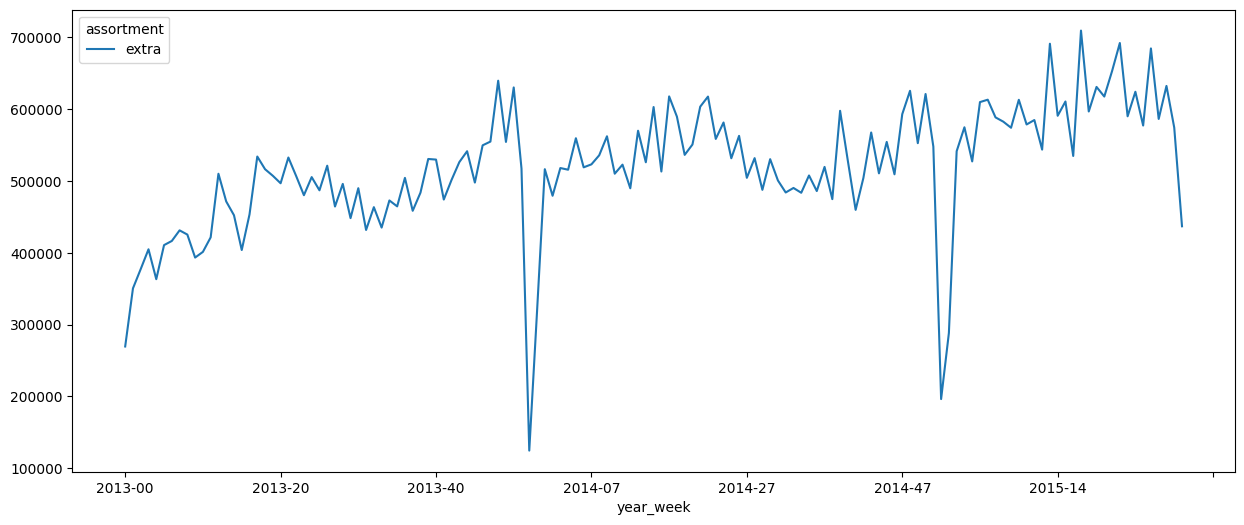

In [42]:
# H1. Stores with more assortment should sell more.

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', hue = 'assortment', palette = 'Set2', data=aux1)

#Validating H1 considering time

aux2 = df4[['year_week', 'assortment', 'sales' ]].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(15, 6))

#Verifying if the extra assortment variable has some behaviour or if it is linear

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(15, 6))


####**Validating H2**. Stores with nearest competitors should sell less.
##### **FALSE** -> **Stores with NEAREST COMPETITORS sell MORE.**


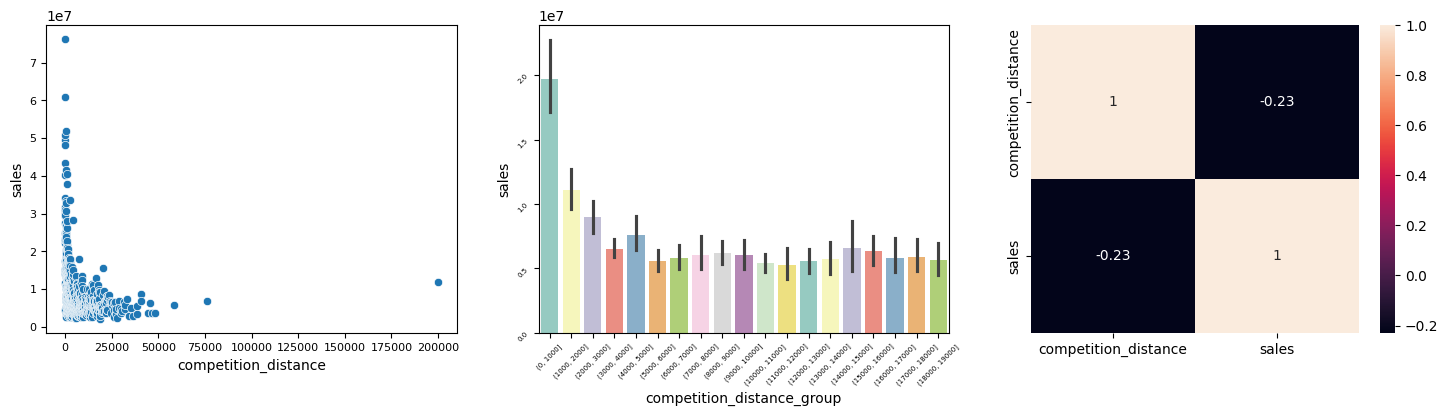

In [43]:
# H2. Stores with nearest competitors should sell less.

#filtering and grouping competition distance and sales data

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

#creating plots

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

#creating scatter plot by competition distance

sns.scatterplot(x='competition_distance', y='sales', data=aux1, ax=axes[0]);
axes[0].tick_params(axis='both', labelsize=8)

#creating groups by competition distance to analyse better the data

bins = list(np.arange(0, 20000, 1000))
aux1 ['competition_distance_group'] = pd.cut(aux1['competition_distance'], bins=bins)

#creating barplot by group competition distance

aux2= aux1[['competition_distance_group', 'sales']].groupby('competition_distance_group', observed=False).sum().reset_index();
sns.barplot(x='competition_distance_group', hue = 'competition_distance_group', palette = 'Set3', y='sales', legend = False, data=aux1, ax=axes[1]);
axes[1].tick_params(axis='both', labelsize=5, rotation = 45)

#creating barplot by group competition distance

numeric_columns = aux1.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True, ax=axes[2]);



####**Validating H3**. Stores that have been with competitors for longer should sell more.
#####**FALSE** -> **Stores that have been with competitors for longer sell LESS/Stores with recent competitors sell MORE.** ps.: this can be observed as more near zero on the x-axis (the current date minus the opened competitor date) more sales.

<ipython-input-44-d37ab769ea35>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot( x='competition_time_month', y='sales', data=aux2, palette='husl', ax=axes[0]);


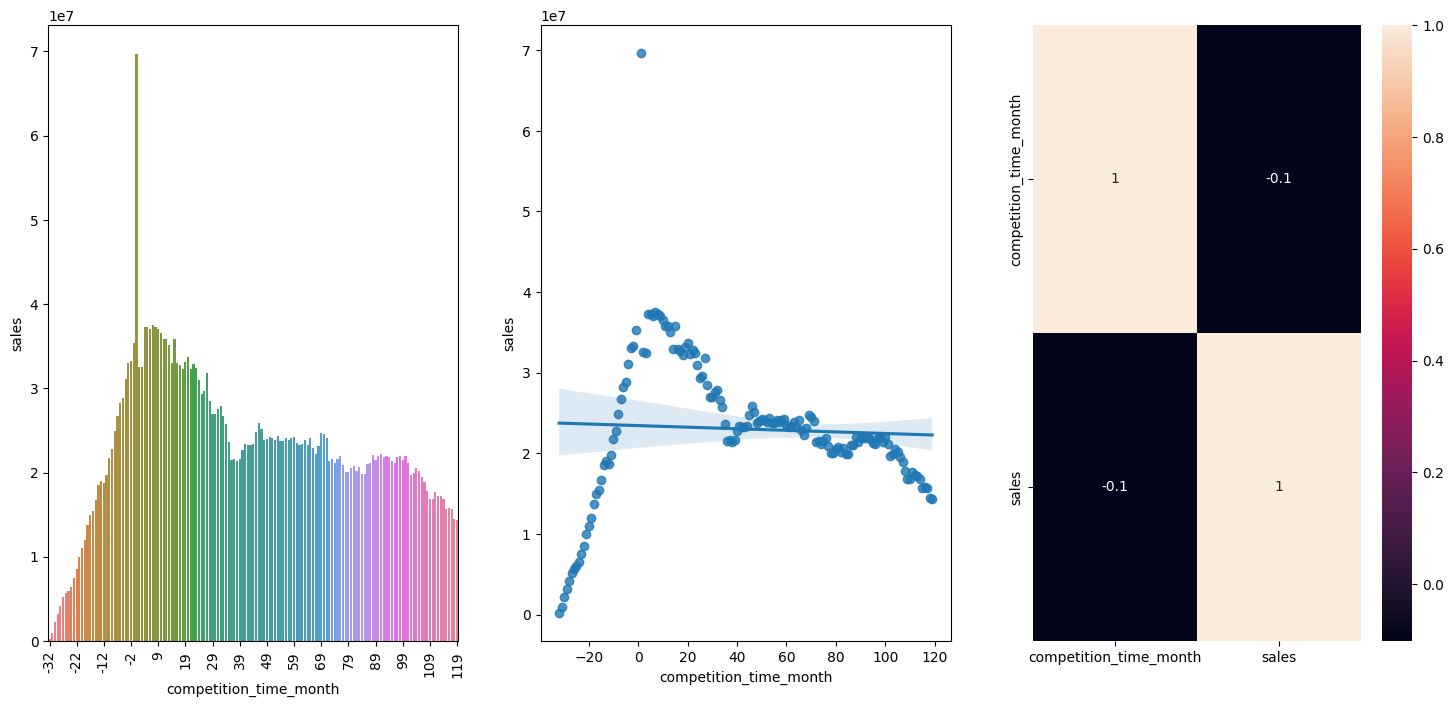

In [44]:
#filtering and grouping competition distance and sales data

aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]

#creating plots

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

#creating scatter plot by competition time month

bar_plot = sns.barplot( x='competition_time_month', y='sales', data=aux2, palette='husl', ax=axes[0]);
bar_plot.set_xticks(bar_plot.get_xticks()[::10])
bar_plot.tick_params(axis='x', rotation=90);


#creating regplot

sns.regplot( x='competition_time_month', y='sales', data=aux2, ax=axes[1] );

#creating heatmap

sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2]);


####**Validating H4**. Stores with active promotions for longer should sell more.
#####**FALSE** -> **Stores with active promotions for longer sell less after a certain period of time.**

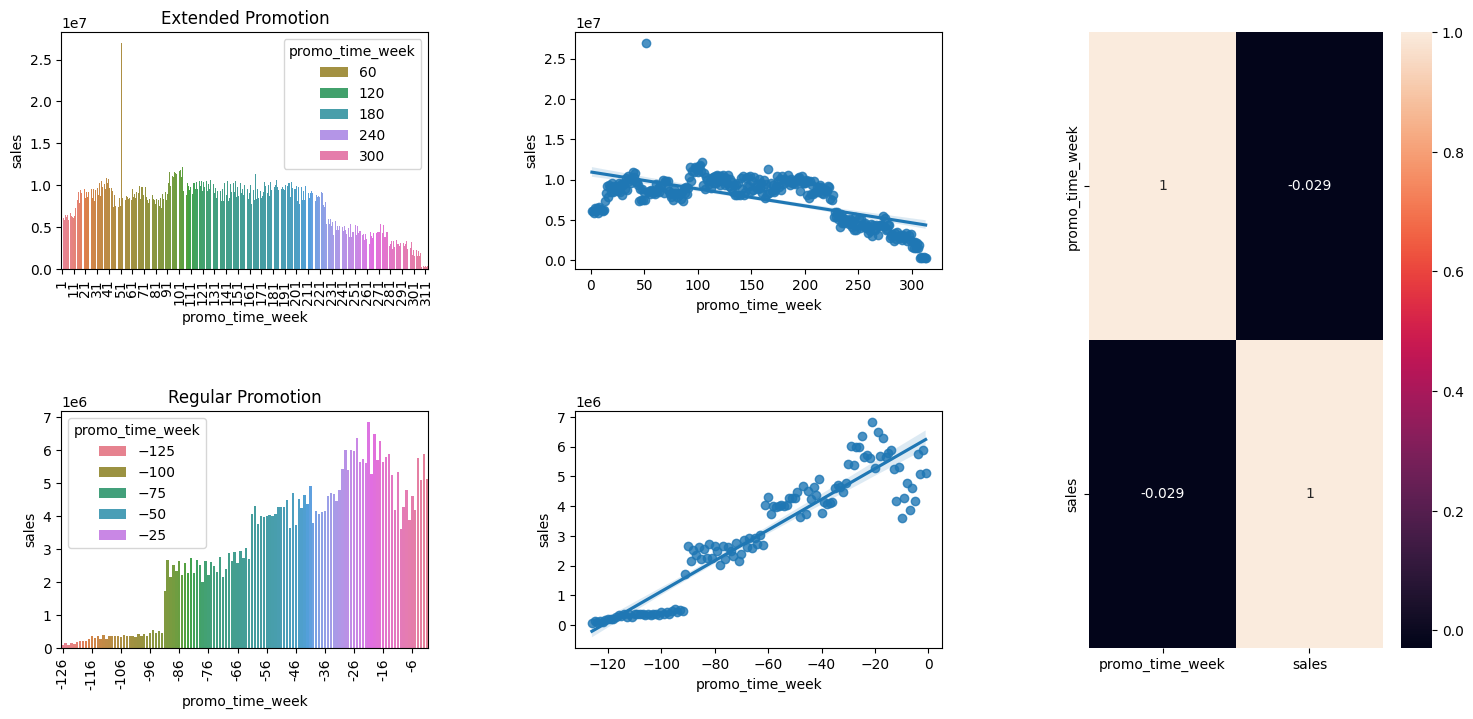

In [45]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

#creating plots
fig = plt.figure(figsize=(18, 8))
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.6)

#barplot to extended promotion

ax1 = fig.add_subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promotion -> this data break is only a strategy to see better the data, but the model treats 'promo_time_week' as a unique variable
bar_plot = sns.barplot(x='promo_time_week', hue = 'promo_time_week', y='sales', data=aux2, palette = 'husl', ax=ax1);
bar_plot.set_title('Extended Promotion')
bar_plot.set_xticks(bar_plot.get_xticks()[::10])
bar_plot.tick_params(axis='x', rotation=90);

#regplot to extended promotion
ax2 = fig.add_subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2, ax=ax2);

#barplot to regular promotion
ax3 = fig.add_subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promotion
bar_plot = sns.barplot(x='promo_time_week', hue = 'promo_time_week', y='sales', data=aux3, palette='husl', ax=ax3);
bar_plot.set_title('Regular Promotion')
bar_plot.set_xticks(bar_plot.get_xticks()[::10])
bar_plot.tick_params(axis='x', rotation=90);

#regplot to regular promotion
ax4 = fig.add_subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3, ax=ax4);

#heatmap
ax5 = fig.add_subplot(grid[:, 2])
sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=ax5);

#adjusting spacement
plt.subplots_adjust(hspace=0.5)

####<s>**Validating H5**. Stores with more promotions days should sell more.</s>

####**Validating H6**. Stores with consecutve promotions should sell more.
#####**FALSE** -> **Stores with consecutve promotions sell less.**

In [46]:
#analysing regular promo and extended promo volume sales

promos = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()
promos.sort_values('sales', ascending=True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


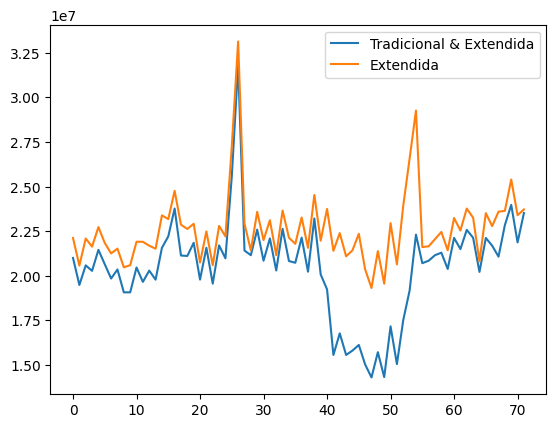

In [47]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

####**Validating H7**. Stores open during the Christmas holiday should sell more.
#####**FALSE** -> **Stores open during the Christmas holiday sell less.**

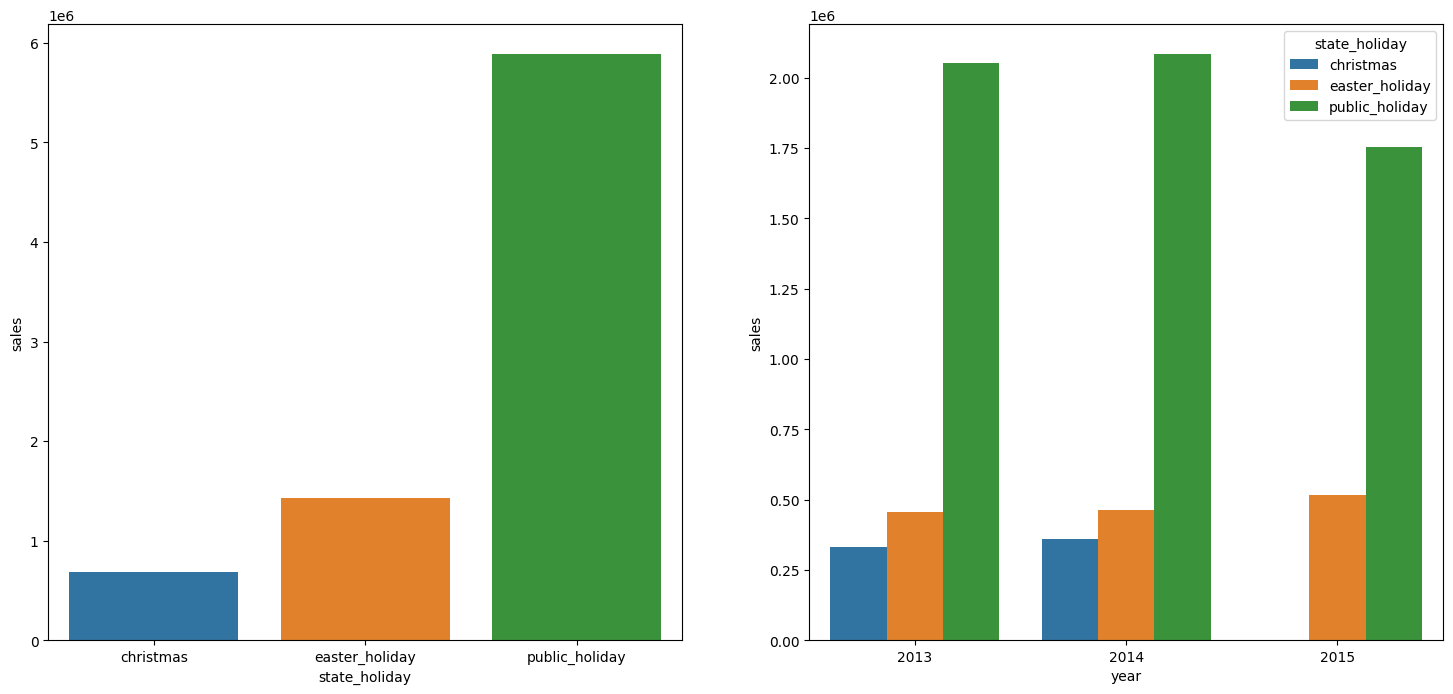

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

df4_filtered = df4[df4['state_holiday'] != 'regular_day']

aux1 = df4_filtered[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', hue='state_holiday', data=aux1, ax = axes[0]);

aux2 = df4_filtered[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2, ax = axes[1]);

####**Validating H8**. Stores should sell more over the years.
#####**FALSE** -> **Stores sell less over the years.**

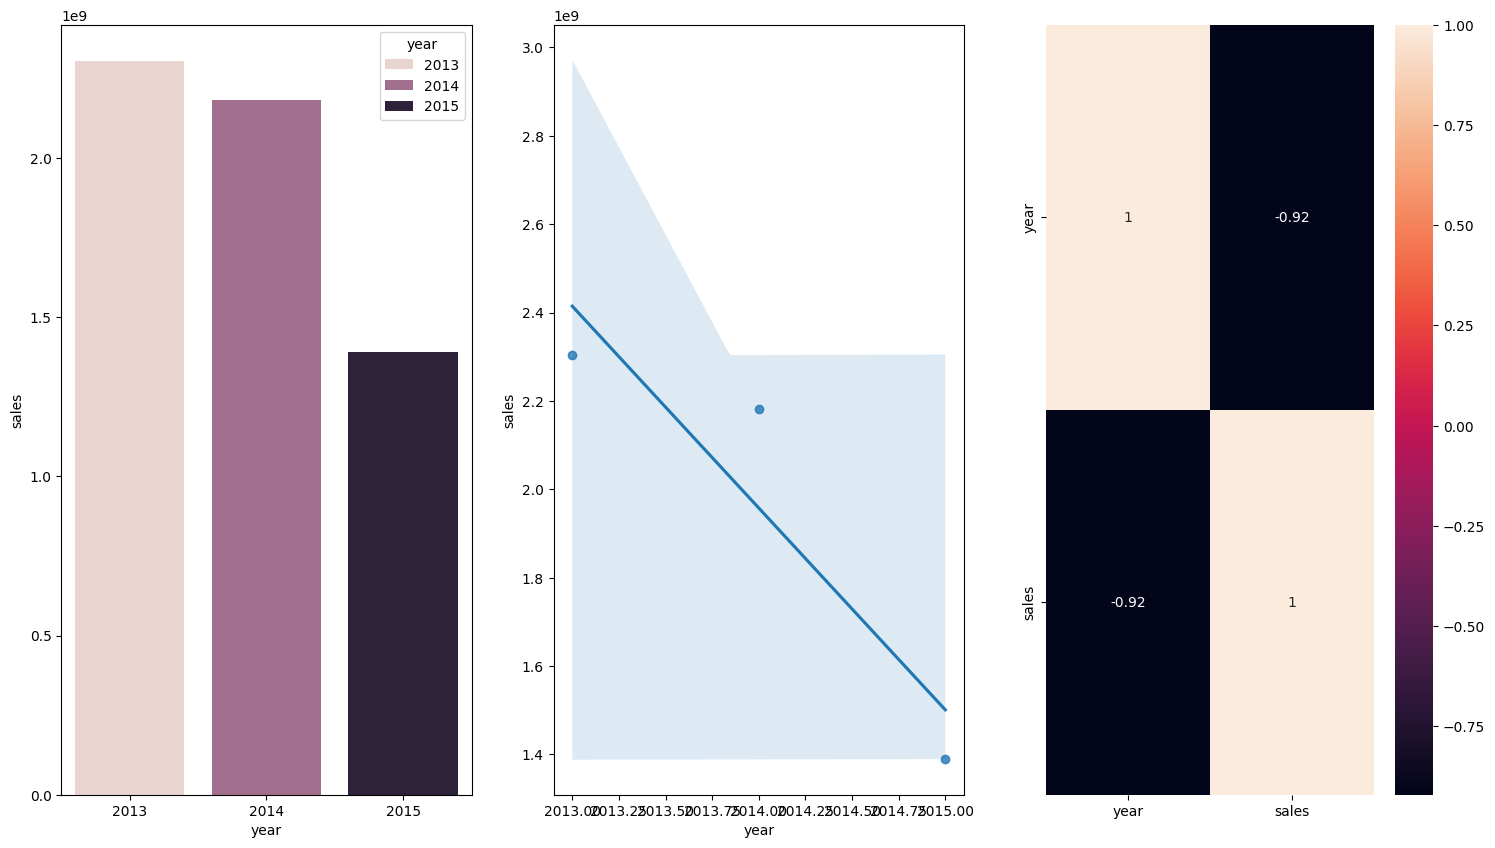

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

sns.barplot(x='year', y='sales', hue = 'year', data=aux1, ax=axes[0]);

sns.regplot(x='year', y='sales', data=aux1, ax=axes[1]);

sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2]);

####**Validating H9**. Stores should sell more in the second semester.
#####**FALSE** -> **Stores sell less in the second semester.**

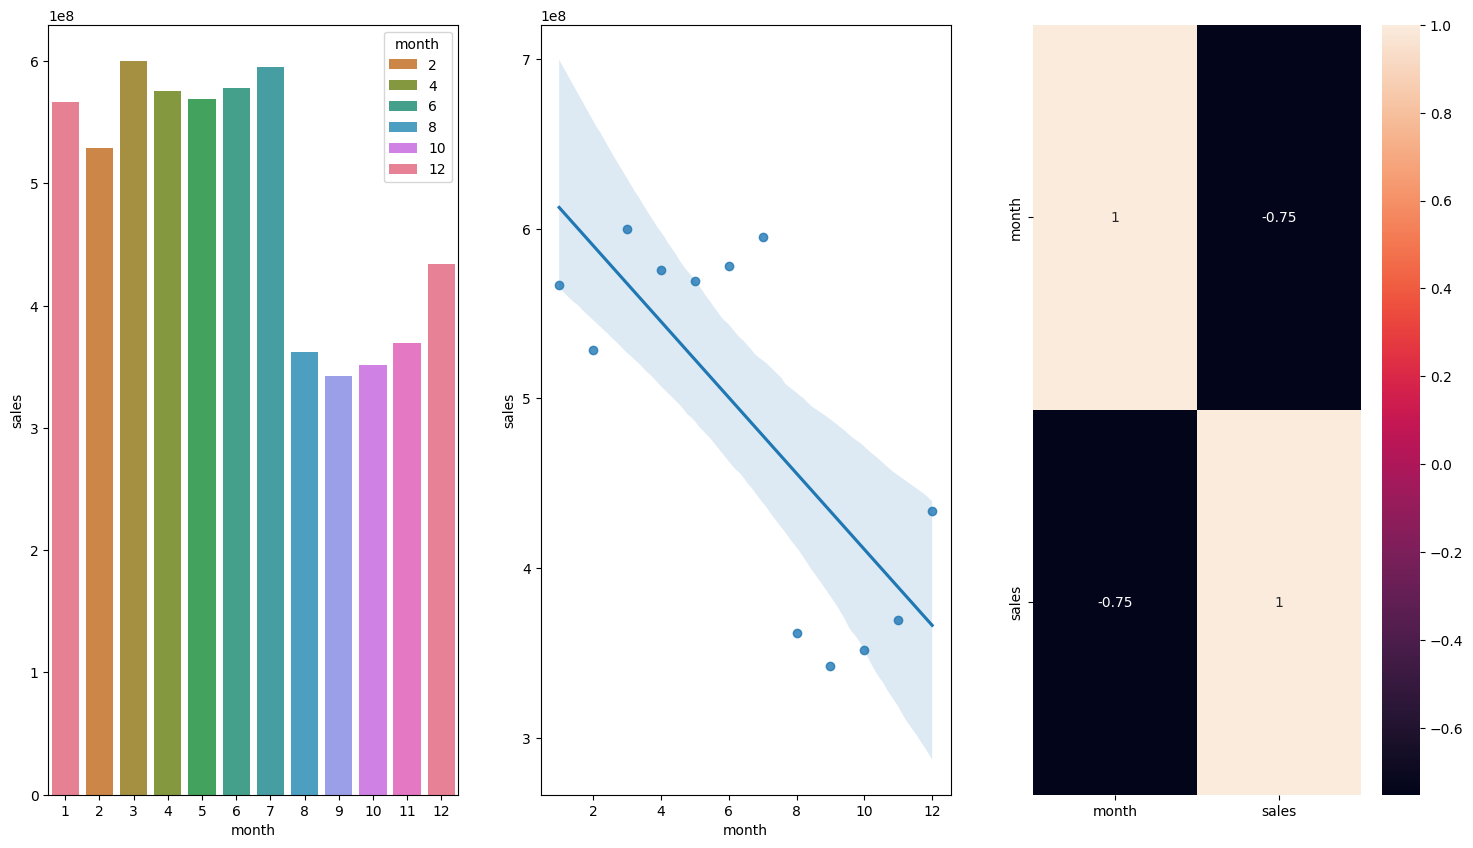

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

sns.barplot(x='month', y='sales', hue = 'month', palette='husl', data=aux1, ax=axes[0]);

sns.regplot(x='month', y='sales', data=aux1, ax=axes[1]);

sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2]);

####**Validating H10**. Stores should sell more after the 10th of each month.
#####**TRUE** -> **Stores sell more after the 10th day of each month.**

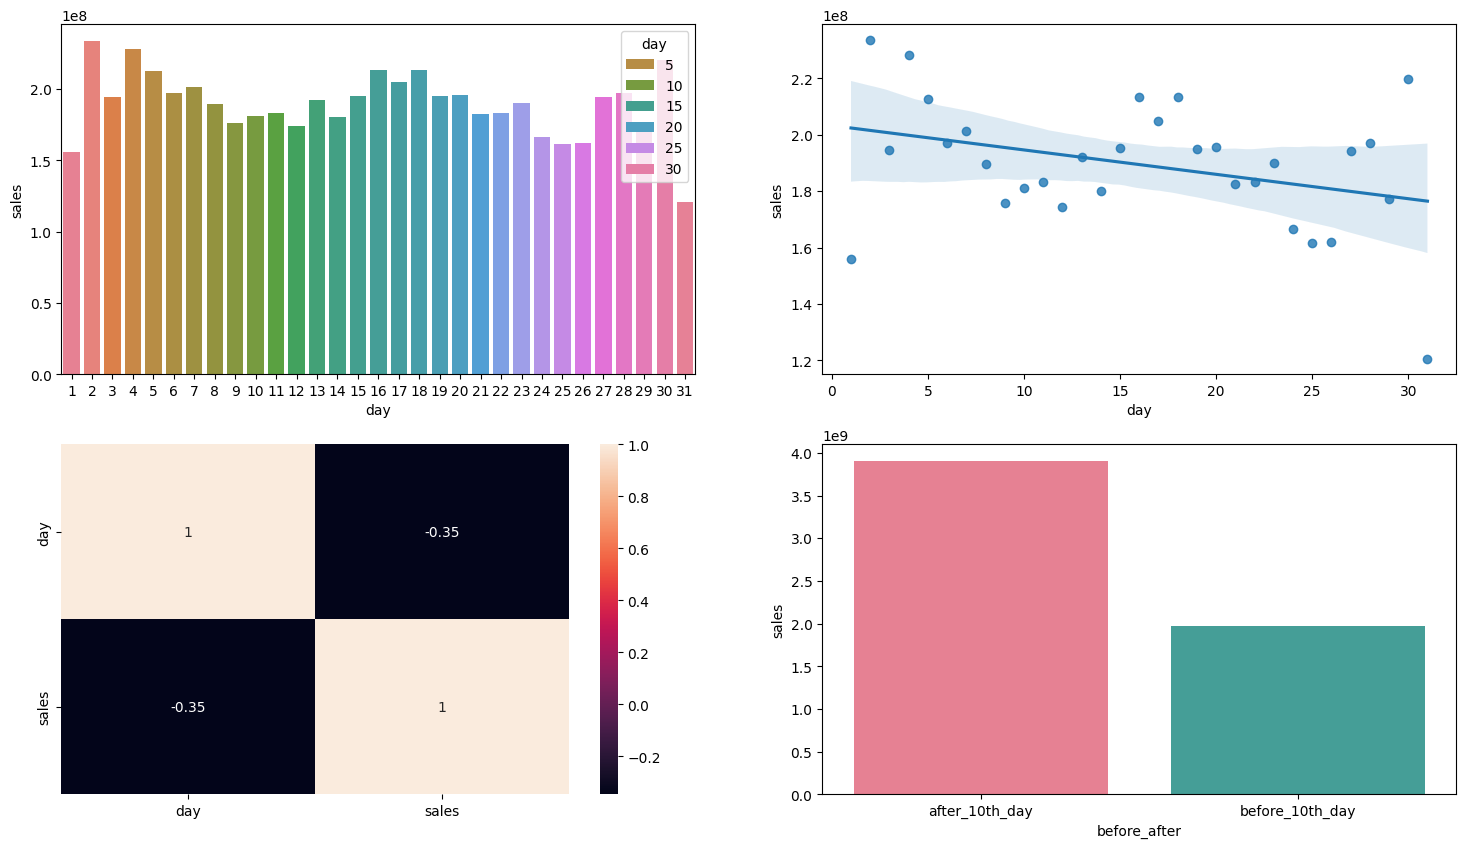

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

sns.barplot(x='day', y='sales', hue = 'day', palette='husl', data=aux1, ax=axes[0][0]);

sns.regplot(x='day', y='sales', data=aux1, ax=axes[0][1]);

sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[1][0]);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10th_day' if x <= 10 else 'after_10th_day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

sns.barplot(x='before_after', y='sales', hue = 'before_after', palette='husl', data=aux2, ax=axes[1][1]);

####**Validating H11**. Stores should sell less on the weekends.
#####**TRUE** -> **Stores sell less on the weekends.**

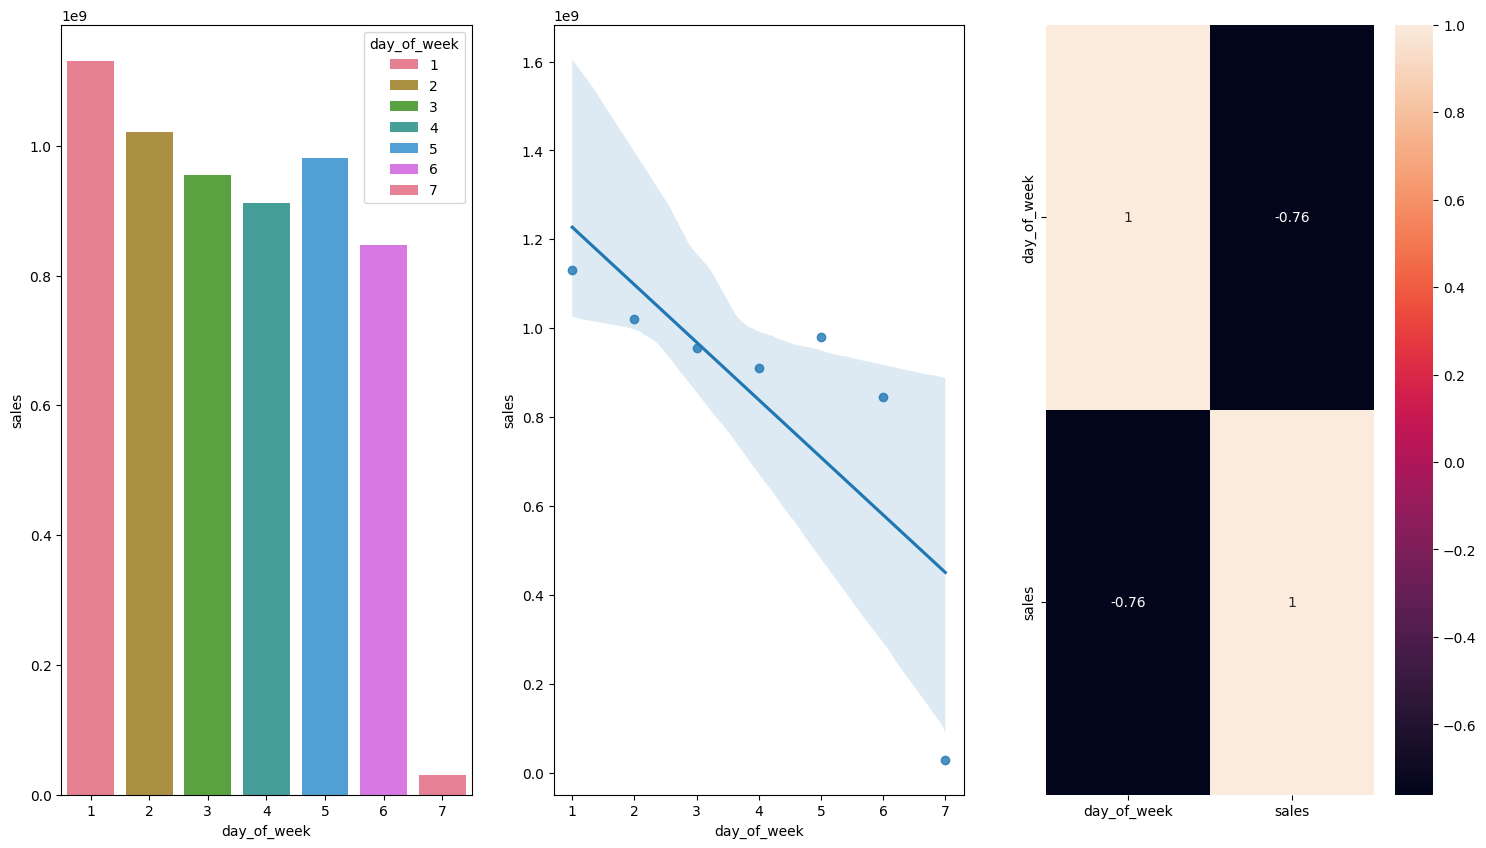

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

sns.barplot(x='day_of_week', y='sales', hue = 'day_of_week', palette='husl', data=aux1, ax=axes[0]);

sns.regplot(x='day_of_week', y='sales', data=aux1, ax=axes[1]);

sns.heatmap( aux1.corr( method='pearson'), annot=True, ax=axes[2]);

####**Validating H12**. Stores should sell less during school holidays.
#####**TRUE** -> **Stores sell less during school holidays, except on in July and August.**

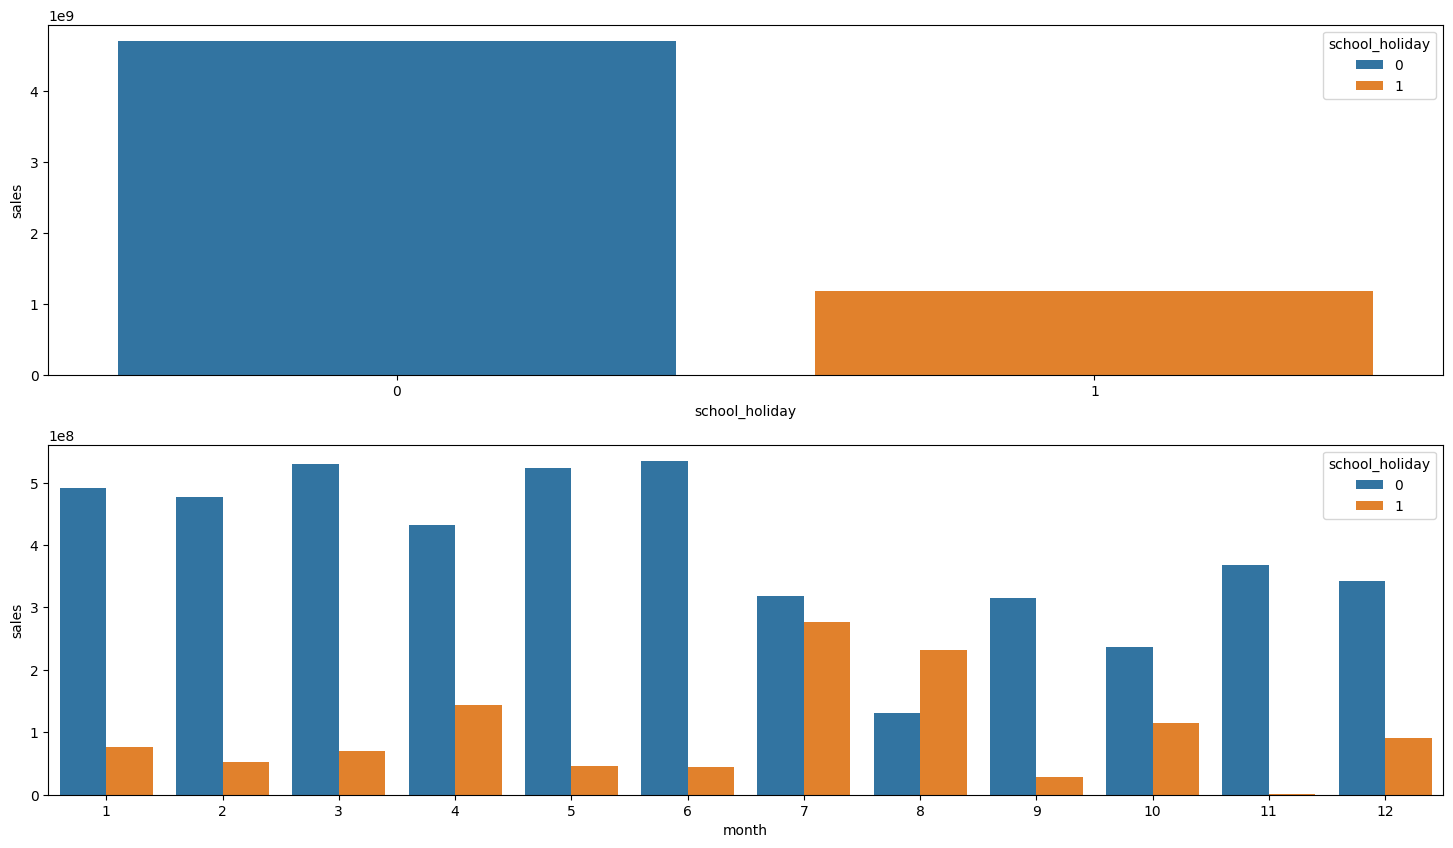

In [53]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', hue = 'school_holiday', data=aux1, ax=axes[0]);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue = 'school_holiday', data=aux2, ax=axes[1]);

####4.3.2.1 Hipostesys Overview

In [54]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


###4.4 Multivariate Analysis

####4.4.1 Numerical Attributes

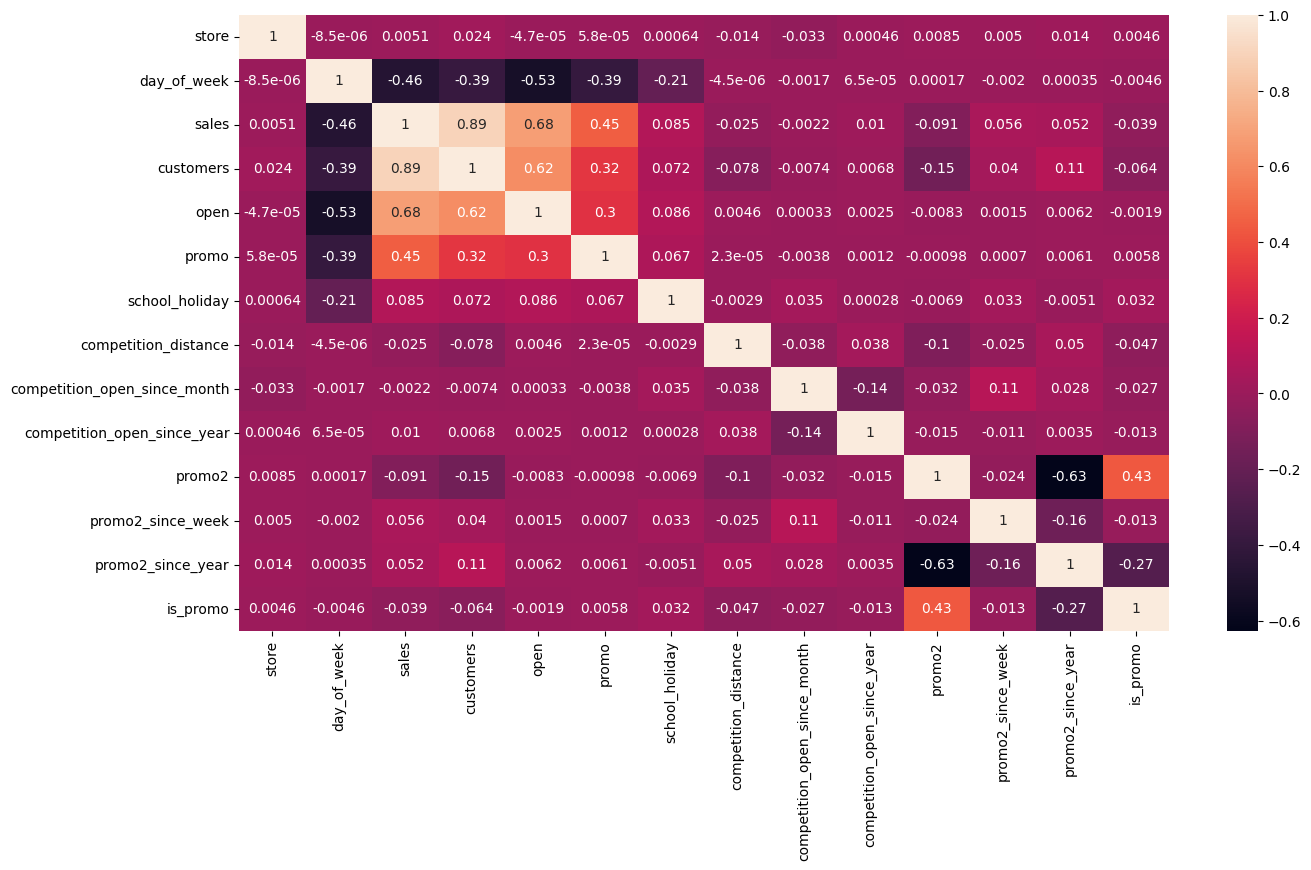

In [55]:
fig = plt.figure(figsize=(15, 8))

correlation_num = num_attributes.corr( method='pearson' )
sns.heatmap( correlation_num, annot=True );

####4.4.2 Categorical Attributes

In [56]:
cat_attributes_2 = df4.select_dtypes(include = 'object')
cat_attributes_2.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [57]:
a1 = cramer_v( cat_attributes_2['state_holiday'], cat_attributes_2['state_holiday'] )
a2 = cramer_v( cat_attributes_2['state_holiday'], cat_attributes_2['store_type'] )
a3 = cramer_v( cat_attributes_2['state_holiday'], cat_attributes_2['assortment'] )
a4 = cramer_v( cat_attributes_2['store_type'], cat_attributes_2['state_holiday'] )
a5 = cramer_v( cat_attributes_2['store_type'], cat_attributes_2['store_type'] )
a6 = cramer_v( cat_attributes_2['store_type'], cat_attributes_2['assortment'] )
a7 = cramer_v( cat_attributes_2['assortment'], cat_attributes_2['state_holiday'] )
a8 = cramer_v( cat_attributes_2['assortment'], cat_attributes_2['store_type'] )
a9 = cramer_v( cat_attributes_2['assortment'], cat_attributes_2['assortment'] )

# Final dataset
dataset = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })

dataset = dataset.set_index( dataset.columns )
dataset

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<Axes: >

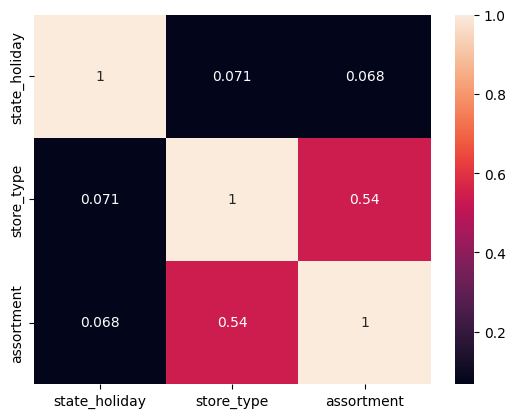

In [58]:
sns.heatmap( dataset, annot=True )

#5.0 DATA PREPARATION

In [59]:
df5 = df4.copy()

##<s>5.1 Normalization</s>

##5.2 Rescaling

In [60]:
df5 = df5.astype({col: 'int64' for col in df5.select_dtypes(include=['int32', 'UInt32']).columns})

In [61]:
df5.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object
assortment,object
competition_distance,float64


In [62]:
num_variables = df5.select_dtypes(include=['int64', 'float64'])
num_variables.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


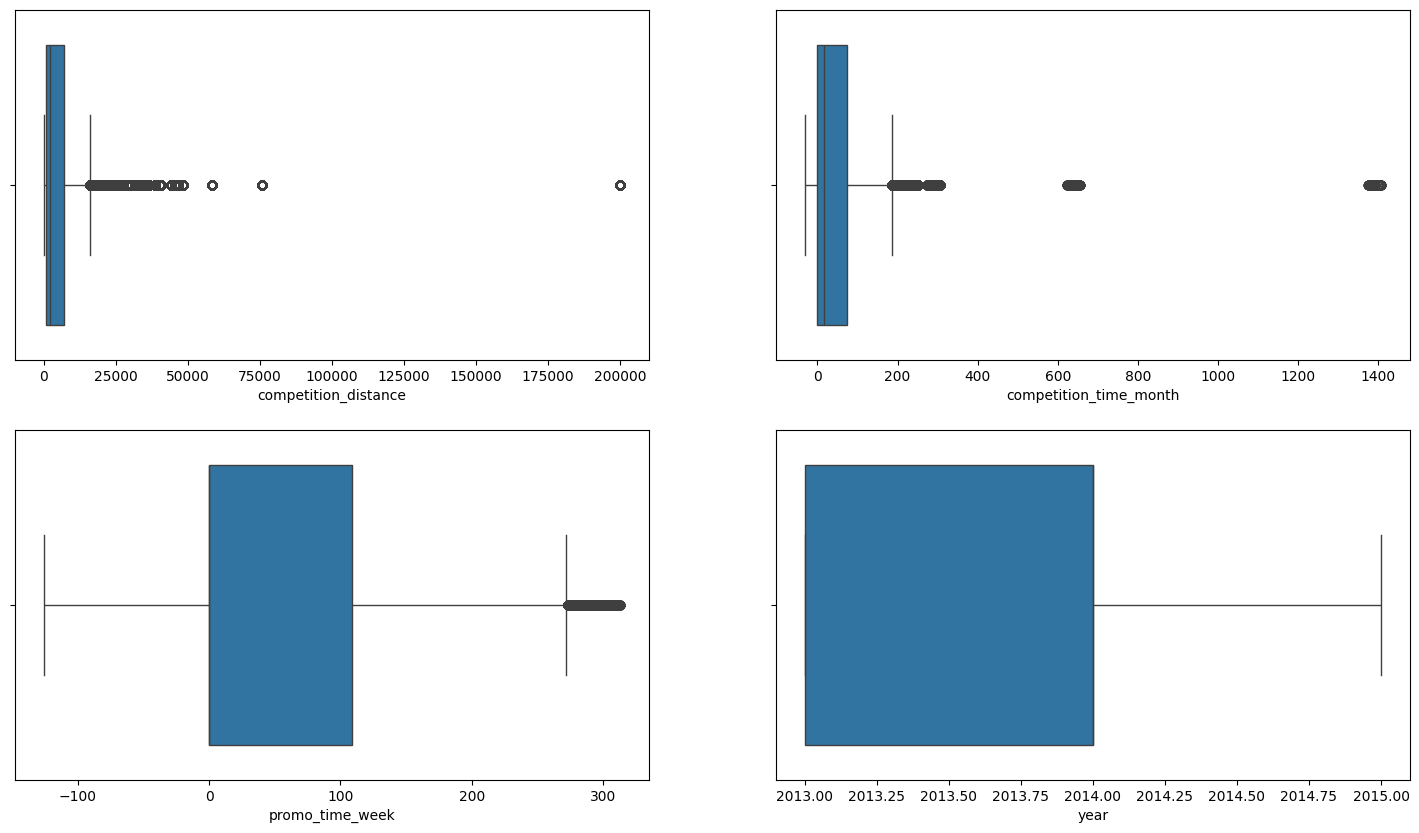

In [63]:
fig, axes = plt.subplots(2, 2 , figsize=(18, 10))

sns.boxplot(x= df5['competition_distance'], ax=axes[0,0]);
sns.boxplot(x= df5['competition_time_month'], ax=axes[0,1]);
sns.boxplot(x= df5['promo_time_week'], ax=axes[1,0]);
sns.boxplot(x= df5['year'], ax=axes[1,1]);

In [64]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distante
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

#competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

#promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

#year
df5['year'] = mms.fit_transform( df5[['year']].values )


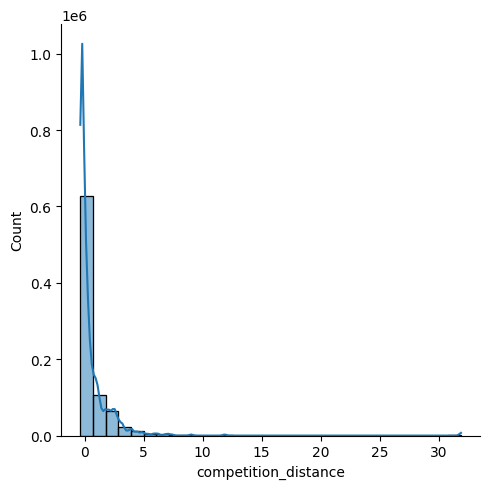

In [65]:
sns.displot(df5['competition_distance'], kde=True, bins=30)

##5.3 Transformation

In [66]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

###5.2.1 Encoding

In [67]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
df5['store_type'] = LabelEncoder().fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )



###5.2.2 Response Variable Transformation

In [68]:
df5['sales'] = np.log1p( df5['sales'] )

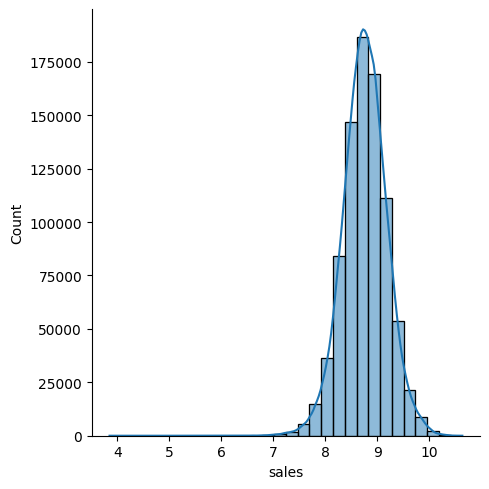

In [69]:
sns.displot(df5['sales'], kde=True, bins=30)

###5.2.3 Nature Transformation


In [70]:
#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )

#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )

#6.0 FEATURE SELECTION

In [71]:
df6 = df5.copy()

##6.1 Split dataframe into training and test dataset

In [72]:
# deleting originals variables that originated derived variables
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
df6 = df6.drop(cols_drop, axis=1)

In [73]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7)

Timestamp('2015-06-19 00:00:00')

In [74]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


##6.2 Boruta as feature selector

In [75]:
# training and test dataset for Boruta

#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#random_forest = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(random_forest, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n)

###6.2.1 Best features from Boruta

In [76]:
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected Boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))

In [77]:
#cols_selected_boruta

In [78]:
#cols_not_selected_boruta

##6.3 Manual Feature Selection

In [85]:
cols_selected_boruta_manual = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta_manual.copy()
cols_selected_boruta_full.extend( feat_to_add )

#7.0 MACHINE LEARNING MODELLING

In [91]:
x_train = X_train[cols_selected_boruta_manual]
x_test = X_test[cols_selected_boruta_manual]

##7.1 Average Model

In [92]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#predictions
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error ( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


##7.2 Linear Regression Model

In [93]:
#model
lr_model = LinearRegression().fit( x_train, y_train )

#predictions
yhat_lr = lr_model.predict( x_test )

#performance
lr_result = ml_error ( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


##7.3 Linear Regression Regularized Model - Lasso

In [94]:
#model
lrlasso_model = Lasso(alpha = 0.01).fit( x_train, y_train )

#predictions
yhat_lrlasso = lrlasso_model.predict( x_test )

#performance
lrlasso_result = ml_error ( 'Linear Regression Lasso', np.expm1(y_test), np.expm1(yhat_lrlasso) )
lrlasso_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1891.704881,0.289106,2744.451737


##7.4 Random Forest Regressor

In [95]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=1, random_state=42).fit( x_train, y_train )

#predictions
yhat_rf = rf.predict( x_test )

#performance
rf_result = ml_error ( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


##7.5 XGBoost Regressor

In [98]:
#model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=100,
                                 eta=0.01,
                                 max_depth=10,
                                 subsample=0.7,
                                 colsample_bytree=0.9).fit( x_train, y_train )

#predictions
yhat_xgb = xgb_model.predict( x_test )

#pexgbormance
xgb_result = ml_error ( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1686.113248,0.250267,2466.301185


##7.6 Compare Model's Performance

In [110]:
modelling_performance = pd.concat([baseline_result, lr_result, lrlasso_result, rf_result, xgb_result])
modelling_performance.sort_values(by='RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,Average Model,1354.800353,0.206400,1835.135542
0,XGBoost Regressor,1686.113248,0.250267,2466.301185
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression Lasso,1891.704881,0.289106,2744.451737
